## Optuna

Будем тестить как работает optuna на [датасете](https://yadi.sk/d/BNR41Vu3y0c7qA). В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. 

In [1]:
import torch
import optuna
import torchvision 
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy 
from torchvision.datasets import ImageFolder

In [2]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = ImageFolder('./dataset/dataset/train', transform=transform)
val_dataset = ImageFolder('./dataset/dataset/val', transform=transform)


train_dataloader = DataLoader(train_dataset, 
    batch_size=128,
    shuffle=True, 
    num_workers=1) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, 
    batch_size=512,
    shuffle=False, 
    num_workers=1)

In [3]:
f = next(iter(train_dataloader))

In [4]:
f

[tensor([[[[-0.2157, -0.0353, -0.1765,  ..., -0.7647, -1.0000, -0.5137],
           [-0.3098, -0.1216, -0.2235,  ..., -0.5922, -0.5922, -0.1529],
           [ 0.0353,  0.1137, -0.1137,  ..., -0.9686, -0.8980, -0.6471],
           ...,
           [-0.8824, -0.8196, -0.6000,  ...,  0.9686,  1.0000,  0.9843],
           [-0.7176, -0.8824, -0.9216,  ...,  0.9216,  0.9451,  1.0000],
           [-0.6235, -0.7255, -0.8980,  ...,  1.0000,  1.0000,  0.8745]],
 
          [[-0.1608,  0.0196, -0.1216,  ..., -0.7490, -0.9765, -0.4275],
           [-0.2706, -0.0824, -0.1765,  ..., -0.5922, -0.5608, -0.0902],
           [ 0.0353,  0.1137, -0.1137,  ..., -1.0000, -0.8980, -0.6314],
           ...,
           [-0.7961, -0.7333, -0.5059,  ...,  0.9373,  0.9686,  0.9294],
           [-0.6235, -0.7882, -0.8275,  ...,  0.9216,  0.9216,  1.0000],
           [-0.5137, -0.6157, -0.7882,  ...,  1.0000,  1.0000,  0.8510]],
 
          [[-0.2157, -0.0353, -0.1843,  ..., -0.8588, -1.0000, -0.5373],
           [-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


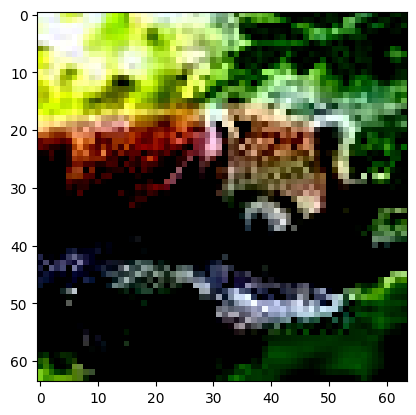

In [5]:
plt.imshow(f[0][8].permute(1, 2, 0))

In [6]:
class YourNet(torch.nn.Module):
    def __init__(self,dropout=0.4, extend = 2, channel =64,extend_lin=4,act ="ELU"):
        super().__init__()
        # -------------------------------------------
        # Архитектура сетки
        # -------------------------------------------
        if act =="ReLU":
            self.act = torch.nn.ReLU()
        elif act == "LeakyReLU": 
             self.act =nn.LeakyReLU(negative_slope=0.01)
        else: 
            self.act = nn.ELU()
        self.batch_norm1 = torch.nn.BatchNorm2d(3)
        #self.batch_norm3 = torch.nn.BatchNorm1d(512)
        #self.batch_norm4 = torch.nn.BatchNorm1d(1024)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv0 = torch.nn.Sequential(nn.Conv2d(in_channels=3, out_channels=channel, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(channel),
        self.act)
        
        self.conv1 = torch.nn.Sequential( 
            torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding = 1),
            torch.nn.BatchNorm2d(channel),
            self.act,
            torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding = 1),
            torch.nn.Dropout(p=dropout),
            torch.nn.BatchNorm2d(channel))
        self.conv2_0 = torch.nn.Conv2d(in_channels=channel, out_channels=channel*extend, kernel_size=3,stride = 2,padding=1)
        self.concat1 = nn.Conv2d(in_channels=channel, out_channels=channel*extend, kernel_size=1, stride=2)
        channel = channel*extend
        self.conv2_1 = torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding=1)
        self.conv2 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channel),
            self.act,
            torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding=1),
            torch.nn.Dropout(p=dropout),
            torch.nn.BatchNorm2d(channel)
        )
        self.conv3_0 = torch.nn.Conv2d(in_channels=channel, out_channels=channel*extend, kernel_size=3,stride = 2,padding=1)
        self.concat2 = nn.Conv2d(in_channels=channel, out_channels=channel*extend, kernel_size=1, stride=2)
        channel=channel*extend
        self.conv3_1 = torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding=1)
        self.conv3 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channel),
            self.act,
            torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding=1),
            torch.nn.Dropout(p=dropout),
            torch.nn.BatchNorm2d(channel)
        )
        self.conv4_0 = torch.nn.Conv2d(in_channels=channel, out_channels=channel*extend, kernel_size=3,stride = 2,padding=1)
        self.concat3 = nn.Conv2d(in_channels=channel, out_channels=channel*extend, kernel_size=1, stride=2)
        channel= channel*extend
        
        self.conv4_1 = torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding=1,groups=8)
        self.conv4 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channel),
            self.act,
            torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding=1),
            torch.nn.Dropout(p=dropout),
            torch.nn.BatchNorm2d(channel)
        )
        self.conv5_0 = torch.nn.Conv2d(in_channels=channel, out_channels=channel*extend, kernel_size=3,stride = 2,padding=1)
        self.concat4 = nn.Conv2d(in_channels=channel, out_channels=channel*extend, kernel_size=1, stride=2)
        channel=channel*extend
        
        self.conv5_1 = torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding=1)
        self.conv5 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channel),
            self.act,
            torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3,padding=1),
            torch.nn.Dropout(p=dropout),
            torch.nn.BatchNorm2d(channel)
        )
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=1)
    
        self.linear1 = torch.nn.Sequential(torch.nn.Linear(in_features=channel, out_features=channel*extend_lin),
         self.act,
         torch.nn.BatchNorm1d(channel*extend_lin))                                  
        self.linear3 = torch.nn.Sequential(torch.nn.Linear(in_features=channel*extend_lin, out_features=channel),
         self.act,
         torch.nn.BatchNorm1d(channel))  
        self.output = torch.nn.Linear(in_features=channel, out_features=200)
        self.relu = self.act
        # -------------------------------------------
        #Вспомогательные параметры и функции
        # -------------------------------------------
        #self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

        
    def forward(self, x):
      #block - 0
        x = self.conv0(x)
        y = self.maxpool(x)
      # block - 1
        x = self.conv1(y)
        y= self.relu(x+y)
      #block - 2
        x = self.conv2_0(y)
        x = self.conv2(x)
        y= self.relu(self.concat1(y)+x)
      #block - 3
        x = self.conv3_0(y)
        x=self.conv3(x)
        y=self.relu(self.concat2(y)+x)
      # block - 4
        x = self.conv4_0(y)
        x=self.conv4(x)
        y=self.relu(self.concat3(y)+x)
     # block - 5
        x = self.conv5_0(y)
        x=self.conv5(x)
        y=self.relu(self.concat4(y)+x)
        x = self.avgpool(y)
      # block - classifier
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear3(x)
        return self.output(x)
    
        
    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor() 
        return self.accuracy

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
def objective(trial):
    dropout = trial.suggest_float("dropout", 1e-2, 9*1e-1)
    extend = trial.suggest_int("extend", 2, 4)
    channel = trial.suggest_int("channel", 8, 128)
    extend_lin= trial.suggest_int("extend_lin", 2, 8)
    act = trial.suggest_categorical("act", ["ReLU", "ELU", "LeakyReLU"])
    model = YourNet(dropout=dropout).to(device)